In [2]:
import numpy as np
np.set_printoptions(suppress=True)
import cv2
from glob import glob
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io as sio
import scipy.ndimage as ndi
from scipy.signal import convolve2d, convolve
from skimage.morphology import skeletonize, remove_small_objects
from skimage.measure import label, regionprops
from skimage.color import label2rgb

In [3]:
class TracerNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(4, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(576, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.regressor(x)
        x = F.normalize(x, dim=1)
        return x

In [4]:
# ported from https://github.com/tsogkas/matlab-utils/blob/master/nms.m
def contour_orient(E, r):
    if r <= 1:
        p = 12 / r / (r + 2) - 2
        f = np.array([1, p, 1]) / (2 + p)
        r = 1
    else:
        f = np.concatenate([np.arange(1, r+1), [r+1], np.arange(r, 0, -1)]) / (r + 1)**2
    E2 = np.pad(E, [r, r], mode='symmetric')
    E2 = convolve(convolve(E2, f[np.newaxis], mode='valid'), f[:, np.newaxis], mode='valid')
    grad_f = np.array([-1, 2, -1])
    Dx = convolve2d(E2, grad_f[np.newaxis], mode='same')
    Dy = convolve2d(E2, grad_f[:, np.newaxis], mode='same')
    f = np.array([[1, 0, -1], [0, 0, 0], [-1, 0, 1]])
    F = convolve2d(E2, f, mode='same') > 0
    Dy[F] = -Dy[F]
    return np.mod(np.arctan2(Dy, Dx), np.pi)

def nms(E, r=3, s=1):
    O = contour_orient(E, r)
    
    Dx = np.cos(O)
    Dy = np.sin(O)
    
    ht, wd = E.shape
    E1 = np.pad(E, r+1, mode='edge')
    
    cs, rs = np.meshgrid(np.arange(wd), np.arange(ht))

    for i in range(-r, r+1):
        if i == 0: continue
        cs0 = i * Dx + cs
        dcs = cs0 - np.floor(cs0)
        cs0 = np.floor(cs0).astype(int)
        
        rs0 = i * Dy + rs
        drs = rs0 - np.floor(rs0)
        rs0 = np.floor(rs0).astype(int)
        
        rs0_p = rs0 + r + 1
        cs0_p = cs0 + r + 1

        rs0_p = np.clip(rs0_p, 0, ht + 2*r)
        cs0_p = np.clip(cs0_p, 0, wd + 2*r)
        
        E2 = (1 - dcs) * (1 - drs) * E1[rs0_p + 0, cs0_p + 0]
        E2 += dcs * (1 - drs) * E1[rs0_p + 0, cs0_p + 1]
        E2 += (1 - dcs) * drs * E1[rs0_p + 1, cs0_p + 0]
        E2 += dcs * drs * E1[rs0_p + 1, cs0_p + 1]

        E[E * 1.01 < E2] = 0

    for i in range(s):
        scale = (i) / s
        E[i, :] *= scale
        E[-i-1, :] *= scale
        E[:, i] *= scale
        E[:, -i-1] *= scale

    return E 

In [5]:
def chboards(height, width, bss):
    num_blocks_x = height // bss
    num_blocks_y = width // bss
    checker_pattern = (-1) ** (np.add.outer(np.arange(num_blocks_x), np.arange(num_blocks_y)))
    A = np.kron(checker_pattern, np.ones((bss, bss)))
    return A[:height, :width]

In [6]:
# Adapted from https://gist.github.com/bmabey/4dd36d9938b83742a88b6f68ac1901a6
def bwmorph_endpoints(image):
    image = image.astype(np.int32)
    k = np.array([[1,1,1],[1,0,1],[1,1,1]])
    neighborhood_count = ndi.convolve(image,k, mode='constant', cval=1)
    neighborhood_count[~image.astype(np.bool)] = 0
    return neighborhood_count == 1

In [7]:
def get_neighbors(arr, y, x):
    h, w = arr.shape
    x1, x2 = max(x-1, 0), min(x+2, w)
    y1, y2 = max(y-1, 0), min(y+2, h)
    return arr[y1:y2, x1:x2]

In [8]:
def get_pixel_idx_list(labeled_image):
    labels = np.unique(labeled_image)
    labels = labels[labels != 0]  # Remove background if labeled as 0
    return [np.flatnonzero(labeled_image == label) for label in labels]

In [9]:
def tensor_cropper(image, cp, crop_wind):
    y, x = cp
    half = crop_wind // 2

    y1, y2 = y - half, y + half + (crop_wind % 2)
    x1, x2 = x - half, x + half + (crop_wind % 2)

    # Handle edge cases by clipping indices to valid ranges
    y1, y2 = max(0, y1), min(image.shape[0], y2)
    x1, x2 = max(0, x1), min(image.shape[1], x2)

    return image[y1:y2, x1:x2].astype(np.float32)

In [16]:
def vector_to_angle_deg(preds):
    cos_vals, sin_vals = preds[:, 0], preds[:, 1]
    angles_rad = torch.atan2(sin_vals, cos_vals)
    angles_deg = torch.rad2deg(angles_rad)
    return angles_deg

[  22.568647    -16.183636     -1.8575933   -28.809008     15.554226
   31.81869      22.36271      -1.9168521    18.263609     11.772317
   11.3027315     6.8523393    10.935558     -2.1415231     2.2152648
  -61.7756      -10.121589    -33.1332      -24.545204     -9.492167
  -19.619093     22.699097     11.473081     -4.590977     -8.867111
  -12.712131     50.8373       13.693514      5.464798    -33.590786
  -46.546303    -28.869085    -43.02553      45.23825     -40.774628
   -4.3647976   -25.833597      2.4838662     2.0134923   -15.90753
  -12.694859     -3.792442    -14.224215    -30.999264     11.013009
  -28.818953    -34.039497    -14.508818    -85.5975      -21.792498
   -1.451791    -15.96487      -2.419468    -19.764885    -15.748331
  -32.291294     23.513899     64.47619     -77.25434     -46.60903
   -6.4525776   -43.417706    -80.25575      26.024462    -50.42935
    4.479404     -5.827351    -26.812202     14.045597     -8.187326
  -24.814121     18.57074     -24.23

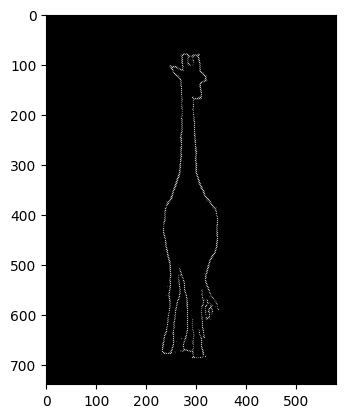

In [19]:
p_step = 3
w_size = 2 * p_step + 1

# Create grid of coordinates relative to center
y, x = np.mgrid[-p_step:p_step+1, -p_step:p_step+1]

# Create mask with border set to 0
center_mask = np.ones((w_size, w_size), dtype=bool)
center_mask[0, :] = False
center_mask[-1, :] = False
center_mask[:, 0] = False
center_mask[:, -1] = False

# Compute angles, shift by pi, convert to degrees
vectormatrix = x + 1j * y
angle_deg = np.degrees(np.angle(vectormatrix) + np.pi)
angle_deg = np.round(angle_deg)

# Function to zero out specified angles in the inner region
def zero_angles(angles, center_mask, target_angles):
    for t in target_angles:
        angles[(angles == t) & center_mask] = 0
    return angles

# Target angles to zero
targets = [0, 45, 90, 135, 180, 225, 270, 315, 360]

# Remove angles where inner mask is True
angle_deg = zero_angles(angle_deg, center_mask, targets)
angle_deg_mirr = np.flipud(angle_deg) * -1

# Get unique angles
unique_angles = np.unique(angle_deg).astype(np.int32)
unique_angles_mirr = np.unique(angle_deg_mirr).astype(np.int32)

imgs = [cv2.imread(file)[...,::-1] for file in glob("data/input/rgb/*")]
contours = [cv2.imread(file, -1) for file in glob("data/input/scm/*")]

# load model
model = TracerNet()
checkpoint = torch.load("data/models/best.pth", weights_only=True)
model.load_state_dict(checkpoint["model_state_dict"])
model.to("cuda")
model.eval()

for img, cont in zip(imgs, contours):
    img = np.flip(img, axis=1).astype(np.float32) * 256
    cont = np.flip(cont, axis=1).astype(np.float32)

    pad_width = [(50, 50), (50, 50)]
    img = np.pad(img, pad_width + [(0, 0)], mode='constant', constant_values=0)
    cont = np.pad(cont, pad_width, mode='constant', constant_values=0)

    thresh = np.max(cont) * 0.5
    non_max_supp = nms(cont, 3, 2)
    non_max_supp[non_max_supp < thresh] = 0
    
    A = chboards(*cont.shape, bss=2)
    non_max_supp[A > 0] = 0
    non_max_supp[non_max_supp > 0] = 1

    BW3 = skeletonize(non_max_supp.astype(bool))
    BW3 = remove_small_objects(BW3, min_size=2, connectivity=8)
    labeled_image, segments = label(BW3, return_num=True)
    stats = regionprops(labeled_image, labeled_image)
    colored_labels = label2rgb(labeled_image, bg_label=0, kind='overlay')

    endpoints_ind = np.zeros((2, segments - 1), dtype=np.int32)
    endpoints_ang = np.zeros((2, segments - 1))
    for i in range(0, segments - 1):
        BW5 = labeled_image == i + 1
        BW5 = ndi.binary_fill_holes(BW5)
        endpoints = bwmorph_endpoints(BW5)

        ind_of_ep = np.flatnonzero(endpoints)
        num_endpoints = len(ind_of_ep)
        if num_endpoints != 2:
            d = np.zeros(num_endpoints)
            props = regionprops(BW5.astype(np.int32))
            x2, y2 = props[0].centroid
            for g, ind in enumerate(ind_of_ep):
                y1, x1 = np.unravel_index(ind, BW5.shape)
                d[g] = np.hypot(x2 - x1, y2 - y1)
            endpoints_ind[:, i] = ind_of_ep[np.argsort(d)[-2:][::-1]]
        else: endpoints_ind[:, i] = ind_of_ep

        r,c = np.unravel_index(endpoints_ind[:,i], BW5.shape)
        endpoints = np.zeros_like(endpoints)
        endpoints[r,c] = 1
        
        for ep_idx in range(2):
            # if numel(indz==1) <- checken
            neighbors = get_neighbors(BW5, r[ep_idx], c[ep_idx])
            neighbors[1, 1] = 0
            dy, dx = np.unravel_index(np.argmax(neighbors), neighbors.shape)
            angle_rad = np.atan2(dy - 1, dx - 1)
            angle_deg = np.degrees(angle_rad) % 360
            endpoints_ang[ep_idx, i] = angle_deg

    ep_all = endpoints_ind.flatten()
    ep_ang_all = endpoints_ang.flatten()

    cps = np.column_stack(np.unravel_index(ep_all, BW5.shape))

    X = cps[:,1]
    Y = cps[:,0]
    prio = cont.flatten()[ep_all].reshape(Y.shape)
    old_angle = ep_ang_all.reshape(Y.shape)
    new_angle = np.zeros_like(old_angle)
    group = labeled_image.flatten()[ep_all].reshape(Y.shape)
    running = np.ones(Y.shape, dtype=np.int32)
    pix_list = get_pixel_idx_list(labeled_image)

    inpu = np.concatenate([img, cont[...,None]], axis=2)
    plt.imshow(inpu[...,3], cmap='gray')
    pix_step = 6
    crop_wind = pix_step*2+1
    extra_crop_wind = crop_wind*2+1
    extra_cp = [crop_wind + 1, crop_wind+1]

    while (runnings := running.sum()) > 0:
        indices = np.argsort(-running)

        # sort arrays
        X = X[indices]
        Y = Y[indices]
        prio = prio[indices]
        old_angle = old_angle[indices]
        new_angle = new_angle[indices]
        group = group[indices]
        running = running[indices]

        cps = np.zeros((runnings, 2))
        cps[:,0] = Y[:runnings]
        cps[:,1] = X[:runnings]

        tracer_input = []
        for laufcp in range(runnings):
            inpu_crop = tensor_cropper(inpu, [Y[laufcp], X[laufcp]], extra_crop_wind)
            inpu_crop_rot = ndi.rotate(inpu_crop, old_angle[laufcp], reshape=False, order=1)
            inpu_crop_rot_crop = tensor_cropper(inpu_crop_rot, extra_cp, crop_wind)
            tracer_input.append(inpu_crop_rot_crop)
        tracer_input = torch.tensor(np.array(tracer_input).transpose(0, 3, 1, 2)).to("cuda")
        with torch.no_grad():
            preds = model(tracer_input).cpu()
            angles = vector_to_angle_deg(preds)
            print(angles.cpu().numpy())
        break
